In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
import time
import logging
import Utility

In [2]:
import importlib
importlib.reload(Utility)

<module 'Utility' from 'C:\\Code\\MyRepo\\00_DeepLearning\\STN-MNIST-Recognition\\Utility.py'>

In [3]:
dataName = 'Rot_NIST'

In [4]:
imgsTrainFile = 'Data/RotNIST_ImgsTrain.npy'
labelsTrainFile = 'Data/RotNIST_LabelsTrain.npy'

imgsValiFile = 'Data/RotNIST_ImgsVali.npy'
labelsValiFile = 'Data/RotNIST_LabelsVali.npy'

In [5]:
imgsTrain = np.load(imgsTrainFile)
labelsTrain = np.load(labelsTrainFile)


In [6]:
imgsTrain.shape

(275000, 28, 28, 1)

In [7]:
labelsTrain.shape

(275000, 10)

In [8]:
randSeed = 123456
np.random.seed(randSeed)
indicesTrain = list(range(imgsTrain.shape[0]))
np.random.shuffle(indicesTrain)

In [9]:
imgsTest = np.load(imgsValiFile)
labelsTest = np.load(labelsValiFile)

In [10]:
imgsTest.shape

(25000, 28, 28, 1)

In [11]:
labelsTest.shape

(25000, 10)

In [12]:
assert imgsTrain.shape[0] == labelsTrain.shape[0]
assert imgsTest.shape[0] == labelsTest.shape[0]

Number corners: 275000


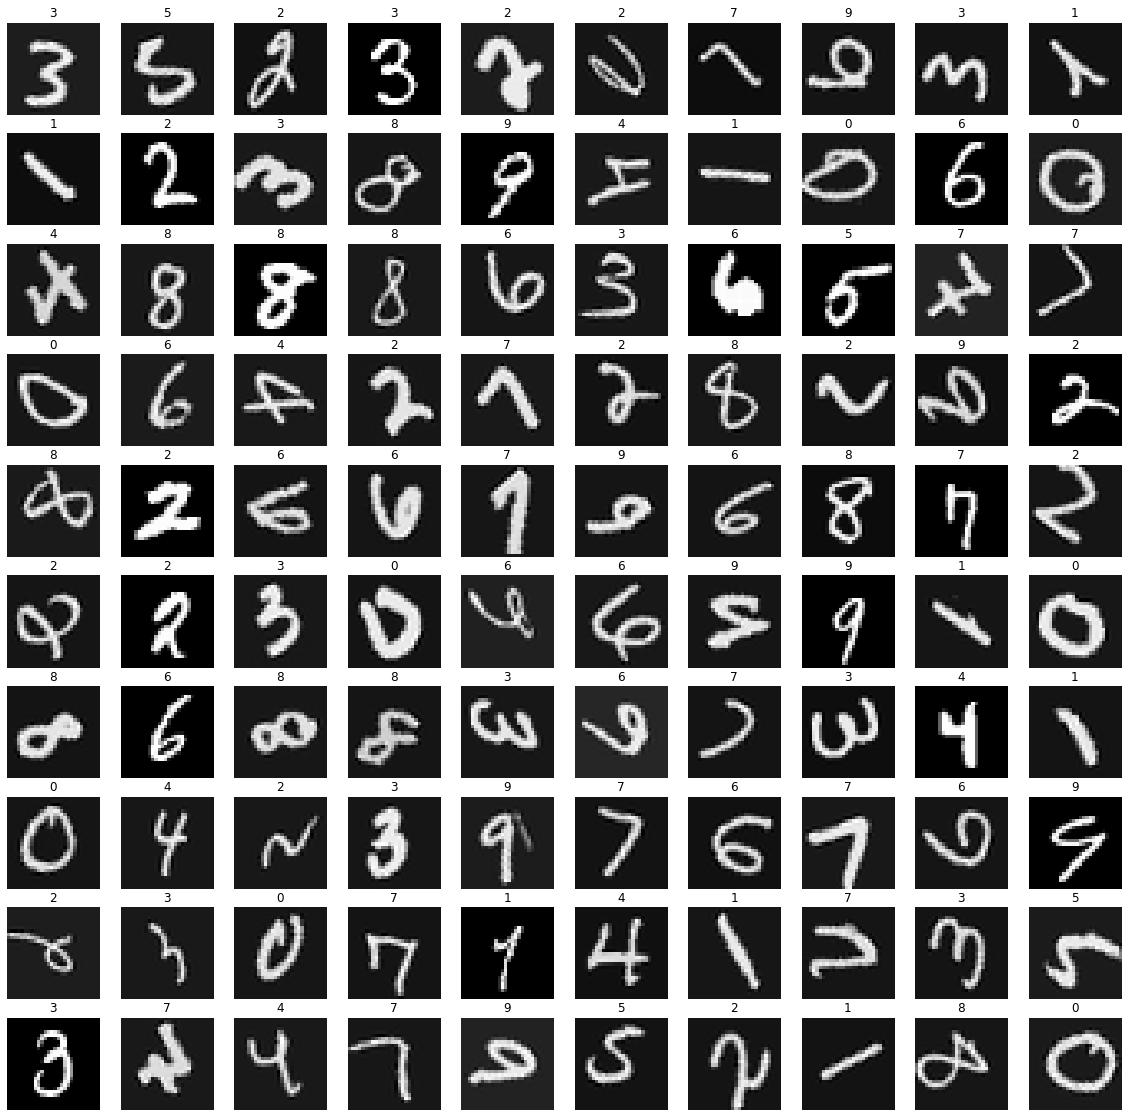

In [13]:
Utility.visualizeAugData(imgsTrain, labelsTrain)

Number corners: 25000


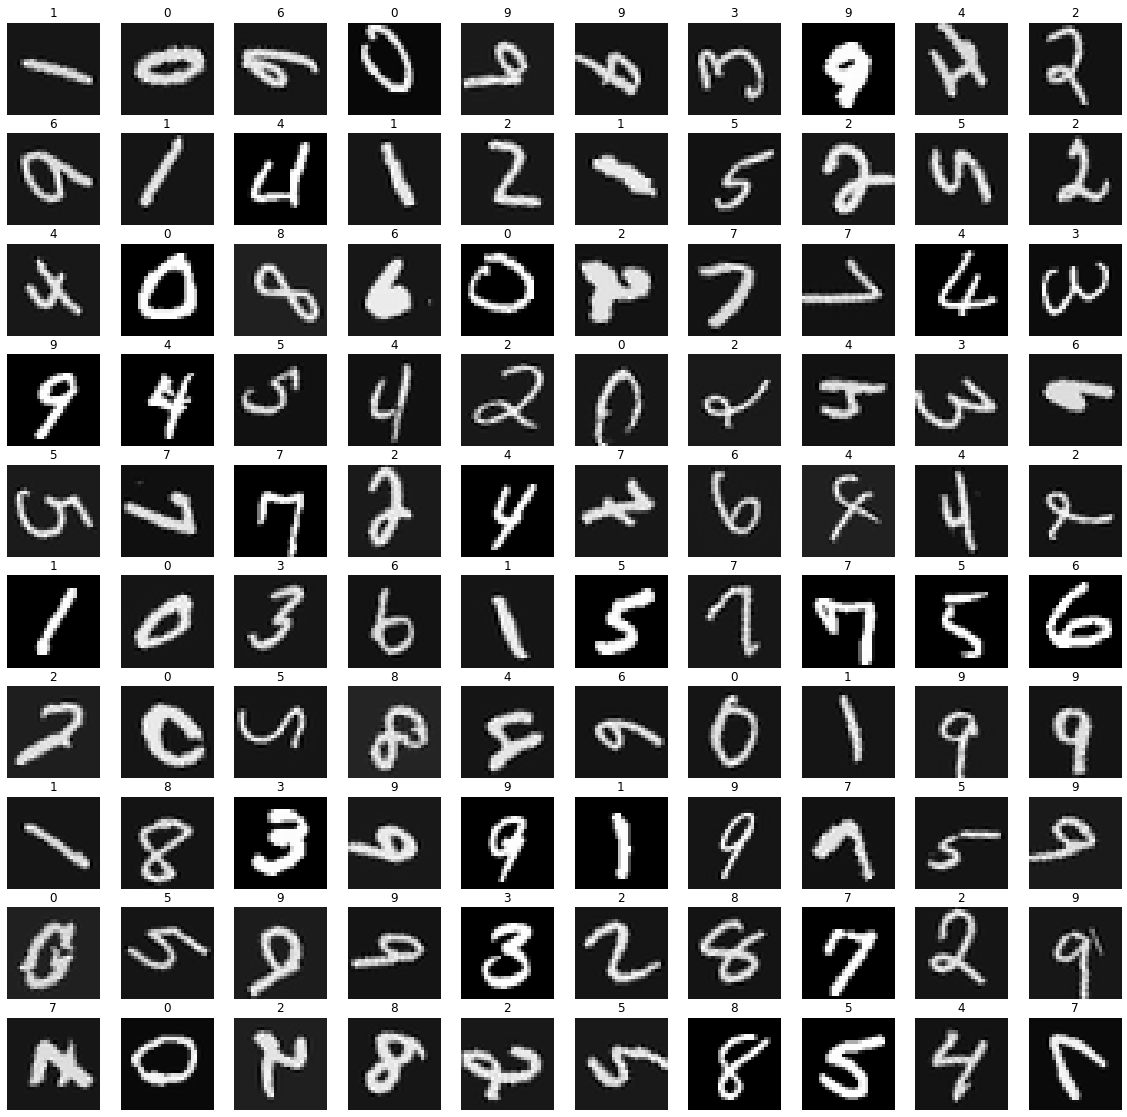

In [14]:
Utility.visualizeAugData(imgsTest, labelsTest)

In [15]:
x_image=tf.placeholder(tf.float32,[None,28, 28, 1], name='x_image')

ys=tf.placeholder(tf.float32,[None,10], 'ys')

keep_prob = tf.placeholder(tf.float32, name='keep_prob')

W_conv1=Utility.weight_variable([5,5,1,32])
b_conv1=Utility.bias_variable([32])

h_conv1=tf.nn.relu(Utility.conv2d(x_image,W_conv1)+b_conv1)
h_pool1=Utility.max_pool_2x2(h_conv1)

W_conv2=Utility.weight_variable([5,5,32,64])
b_conv2=Utility.bias_variable([64])

h_conv2=tf.nn.relu(Utility.conv2d(h_pool1,W_conv2)+b_conv2)
h_pool2=Utility.max_pool_2x2(h_conv2)

h_pool2_flat=tf.reshape(h_pool2,[-1,7*7*64])

W_fc1=Utility.weight_variable([7*7*64,1024])
b_fc1=Utility.bias_variable([1024])

h_fc1=tf.nn.relu(tf.matmul(h_pool2_flat,W_fc1)+b_fc1)
h_fc1_drop=tf.nn.dropout(h_fc1,keep_prob)

W_fc2=Utility.weight_variable([1024,10])
b_fc2=Utility.bias_variable([10])

prediction = tf.nn.softmax(tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2))
cross_entropy=tf.reduce_mean(
    -tf.reduce_sum(ys*tf.log(prediction),
    reduction_indices=[1]))

train_step=tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)


In [16]:
sess = tf.Session()


In [17]:
init = tf.global_variables_initializer()
sess.run(init)

In [18]:
import sys
# ...

logFormatter = logging.Formatter("%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s")
rootLogger = logging.getLogger()

fileHandler = logging.FileHandler( "Log/" + dataName + ".txt")
fileHandler.setFormatter(logFormatter)
rootLogger.addHandler(fileHandler)
rootLogger.addHandler(logging.StreamHandler(sys.stdout))

In [19]:
accTrain = []
accTest = []
batchSize = 5000
# if readWeights:
#     saver = tf.train.Saver()
#     saver.restore(sess, "save/model.ckpt")
# else:
    
print(Utility.compute_accuracy(
           imgsTest[:1000], labelsTest[:1000], prediction, sess))

timeStart = time.clock()


numEpoch = 2000
printStep = 5
numBatchs = int(np.ceil(imgsTrain.shape[0] / batchSize))
for iEpoch in range(numEpoch):
    for iBatch in range(numBatchs):
        batchData = imgsTrain[iBatch*batchSize:(iBatch+1)*batchSize]
        gdData = labelsTrain[iBatch*batchSize:(iBatch+1)*batchSize, :]
        
        sess.run(train_step, feed_dict={x_image: batchData, ys: gdData, keep_prob: 0.65})
    
    if iEpoch % printStep == 0:
        accTrain.append(Utility.compute_accuracy(imgsTrain,
                                         labelsTrain, prediction, sess))
        accTest.append(Utility.compute_accuracy(
            imgsTest, labelsTest, prediction, sess))
        rootLogger.info("Epoch", iEpoch, "Train accuracy:", accTrain[-1], "Test accuracy:", accTest[-1], 
              "Loss on Train batch: ", sess.run(cross_entropy,feed_dict={x_image: batchData, ys: gdData, keep_prob: 1.0}),
                "Time:", time.clock()-timeStart)



0.094


KeyboardInterrupt: 

In [23]:
print("Epoch", iEpoch, "Train accuracy:", accTrain[-1], "Test accuracy:", accTest[-1], 
              "Loss on Train batch: ", sess.run(cross_entropy,feed_dict={x_image: batchData, ys: gdData, keep_prob: 1.0}),
                "Time:", time.clock()-timeStart)

Epoch 175 Train accuracy: 0.99968 Test accuracy: 0.9844 Loss on Train batch:  0.0021215002 Time: 2751.4896422


In [20]:
os.makedirs("save", exist_ok=True)
saver = tf.train.Saver()
saver_path = saver.save(sess, "save/modelCNN.ckpt")

In [21]:
fileHandler.close()

NameError: name 'compute_accuracy' is not defined

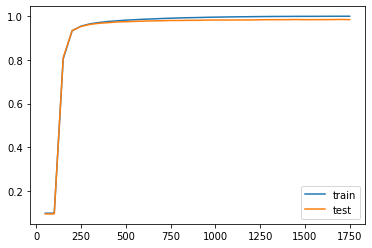

In [22]:
fig, axs = plt.subplots()
x = [(i+1)*50 for i in range(len(accTrain))]

axs.plot(x, accTrain, label='train')
x = [(i+1)*50 for i in range(len(accTest))]
axs.plot(x, accTest, label='test')
axs.legend()
fig.savefig("lossCNN" + dataName + ".pdf", dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

# print(compute_accuracy(
#     imgsTest[:1000], labelsTest[:1000]))

In [27]:
logFile = open("log/" + dataName + ".txt", 'w')
for i in range(min(len(accTest), len(accTrain))):
    logFile.write("Epoch:" +  str(i*5) + " Train accuracy:" + str(accTrain[i]) + " Test accuracy:" + str(accTest[i]) + '\n')

logFile.close()
